# Tracking with SIFT features
The idea of this tracking method is to perform a matching in the n-th frame with the previous one using SIFT fetures.

First frame is going to determine the region of interest and the background. Usign SIFT features, we will extract features for both the region of interest and the background, consequently having two models.

When analyzing the folloring frames, we will apply firstly feature detection, and for each one we will find the closest match in the background model and the object model, which will determine if he point belongs to our region of interest or not. Since the region of interest window will have been displaced, we will recalculate the bounding box of this region.

Once a frame has been analyzed and the region of interest recalculated, we will update both our models, and repeat this same process for the rest of the frames.




In [27]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import sys
import time
import AuxFunctions

In [28]:
def getObjectMask(img, bb):
    mask=np.empty(img.shape, dtype=np.uint8)
    mask.fill((255))
    mask = np.zeros(img.shape, dtype=np.uint8)
    # bounding box region is white
    mask = cv2.rectangle(mask, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,255,255), thickness = -1)
    # convert to grayscale to have only one channel
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

In [30]:
def getBackgroundMask(img, bb):
    mask=np.empty(img.shape, dtype=np.uint8)
    # background is white
    mask.fill((255))
    # bounding box region is black
    mask = cv2.Con(mask, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (0), thickness = -1)
    # convert to grayscale to have only one channel
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

---

In [31]:
def cropObject2gray(img, bb):
    img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [32]:
def getObjectCropped(points, im):   
    pts = points.squeeze()

    # build minimum rectangle
    minX = maxX =  pts[0][0]
    minY = maxY =  pts[0][1]
    for p in pts:
        minX = min(minX, p[0])
        maxX = max(maxX, p[0])
        minY = min(minY, p[1])
        maxY = max(maxY, p[1])
    return cv2.cvtColor(im[minY:maxY, minX:maxX],cv2.COLOR_BGR2GRAY)

In [33]:
def getCroppedBB(img, bb):
    img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [40]:
def runTracker(mainDirectory = "./datasets/MotorcycleChase", maxFramesToShow = 1000, showEveryX=5):
    # get bounding boxes data
    filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
    try:
        bbs = AuxFunctions.getBoundingBoxes(filepathBB)
    except:
        print("Haven't been found the groundtruth_rect.txt file")
        
    # analyze the first frame
    imgPath = os.path.join(mainDirectory, "img")
    file = os.path.join(imgPath, "00001.jpg")
    firstFrame = cv2.imread(file)
    
    
    # extracting features of the first frame ----------------------------------------------------
    sift = cv2.xfeatures2d.SIFT_create() 
    Obj = getCroppedBB(firstFrame, bbs[1])

        # detect features
    objectKp, objectDescriptors = sift.detectAndCompute(Obj, None)
        # draw the detected key points
    #objectFeatures = cv2.drawKeypoints(grayObj, objectKp, Obj)
    
    
    
    
    # iterate through the frames ----------------------------------------------------------------
    FLANN_INDEX_KDTREE = 1
    MINIMUM_MATCHES_COUNT = 5
    
    j = 0
    i = 0
    framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))
    for filename in os.listdir(imgPath)[2:framesToShow]:
        
        # reading the frame
        filepath = os.path.join(imgPath, filename)   
        frame = plt.imread(filepath)
        
        # feature extraction of the frame
        grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frameKp, frameDescriptors = sift.detectAndCompute(frame, None)
            # draw the detected key points
        #frameFeatures = cv2.drawKeypoints(grayFrame, frameKp, frame)
        
        
        # matching of previous and current frame ------------------------------------------------
        
        index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees  =5)
        search_params = dict(checks = 50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(objectDescriptors, frameDescriptors, k=2)

        #store only the best matches filtering with Lowe's test
        bestMatches = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                bestMatches.append(m)

        if len(bestMatches) > MINIMUM_MATCHES_COUNT :
            src_pts = np.float32([ objectKp[m.queryIdx].pt for m in bestMatches ]).reshape(-1,1,2)
            dst_pts = np.float32([ frameKp[m.trainIdx].pt for m in bestMatches ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w = Obj.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            dst = cv2.perspectiveTransform(pts,M)

            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None,
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)

            img3 = cv2.rectangle(frame, np.int32(dst)[0][0], np.int32(dst)[2][0], (255,0,0), thickness=3)
            if i == 0:
                fig,ax = plt.subplots()
                ax.imshow(img3)
                plt.show()            
            
            # recalculate the object ROI
            Obj = getObjectCropped(np.int32(dst), frame)
            objectKp, objectDescriptors = sift.detectAndCompute(Obj, None)
            
            
            i +=1
            i = i%showEveryX
            j+=1

        else:
            print(j)
            return

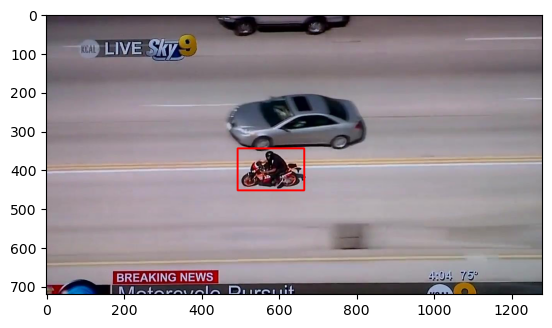

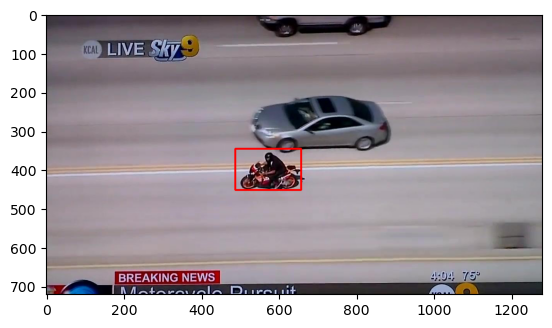

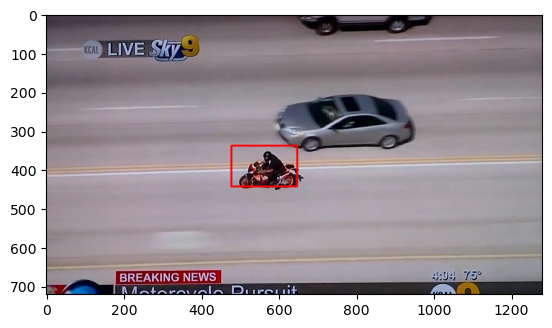

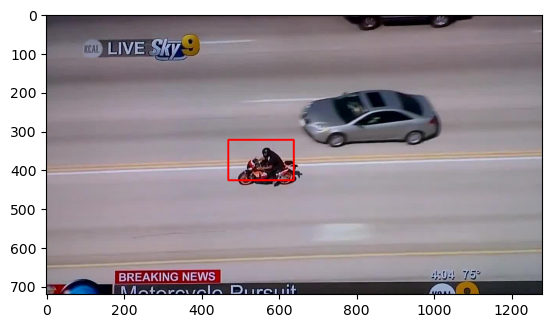

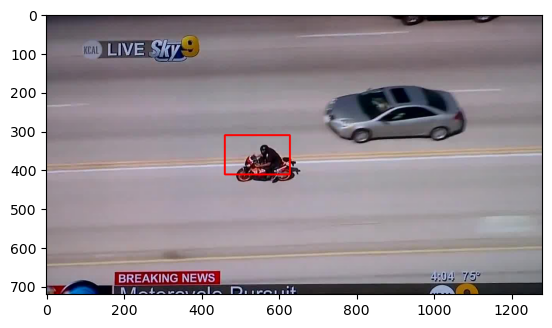

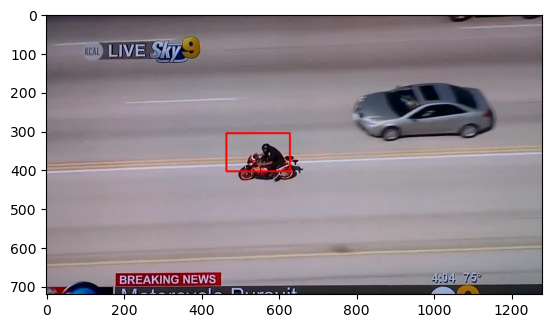

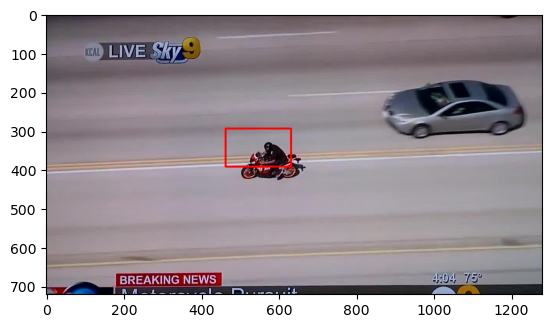

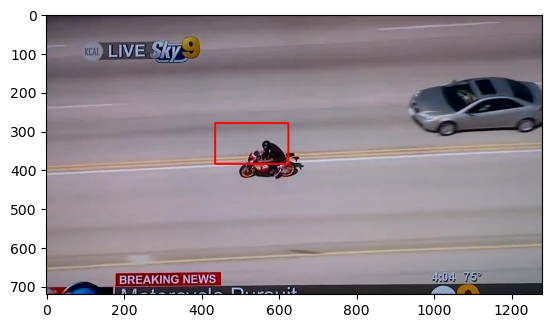

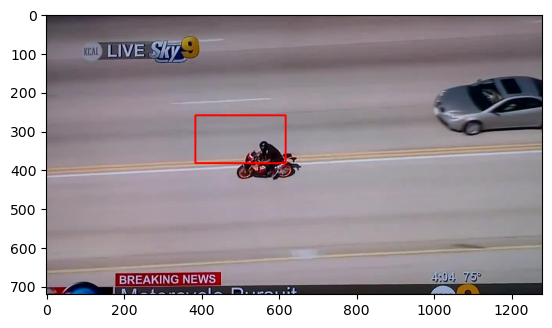

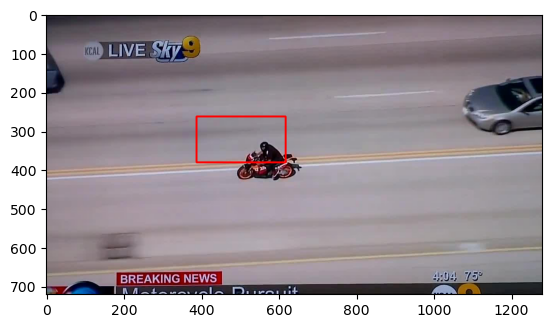

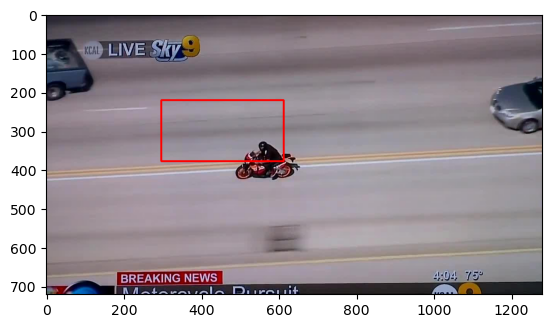

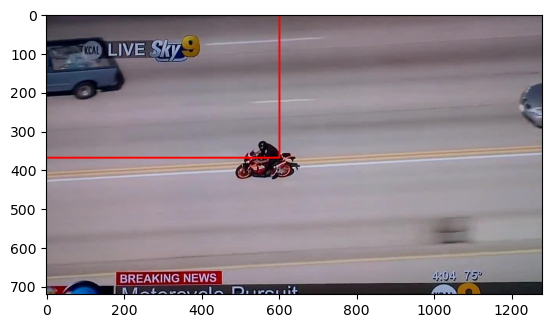

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [39]:
runTracker()